<a href="https://colab.research.google.com/github/Majoramu/Fisica_Computacional1/blob/main/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [ ]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
url = 'https://raw.githubusercontent.com/Majoramu/Fisica_Computacional1/main/Actividad_1/25116.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')
# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19037 entries, 1961-01-01 to 2013-05-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  19037 non-null  float64
 1   Evap    16923 non-null  float64
 2   Tmax    19030 non-null  float64
 3   Tmin    19004 non-null  float64
 4   Año     19037 non-null  int64  
 5   Mes     19037 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.0+ MB


Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la Prueba Aumentada de Dickey-Fuller(ADF)

In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Definimos la serie de tiempo a probar....

In [ ]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2000-01', '2005-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2000-01-01,0.0,2.8,26.0,14.0,2000,Jan
2000-01-02,0.0,2.8,24.0,11.0,2000,Jan
2000-01-03,0.0,4.3,20.0,11.0,2000,Jan
2000-01-04,0.0,3.6,22.0,10.0,2000,Jan
2000-01-05,0.0,2.5,24.0,8.0,2000,Jan


In [ ]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2000-01-01    26.0
2000-01-02    24.0
2000-01-03    20.0
2000-01-04    22.0
2000-01-05    24.0
Name: Tmax, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()

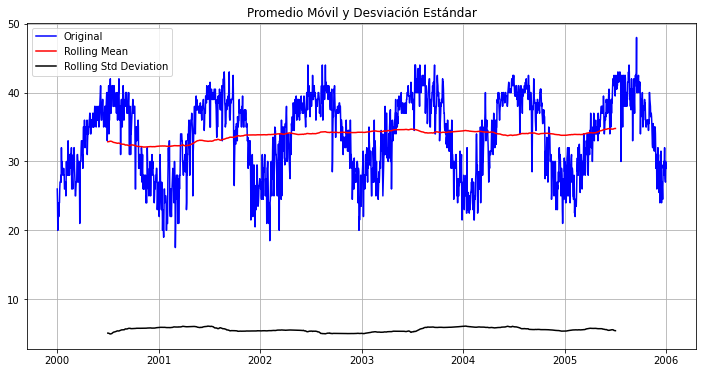

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.196522
p-value                           0.020187
#Lags Used                       12.000000
Number of Observations Used    2179.000000
Critical Value (1%)              -3.433355
Critical Value (5%)              -2.862867
Critical Value (10%)             -2.567477
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

Notamos que el promedio móvil no es constante y el valor p de ADF: p > 0.05 (0.0876).

La tendencia y la estacionalidad hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la Tendencia sea constante.

Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.

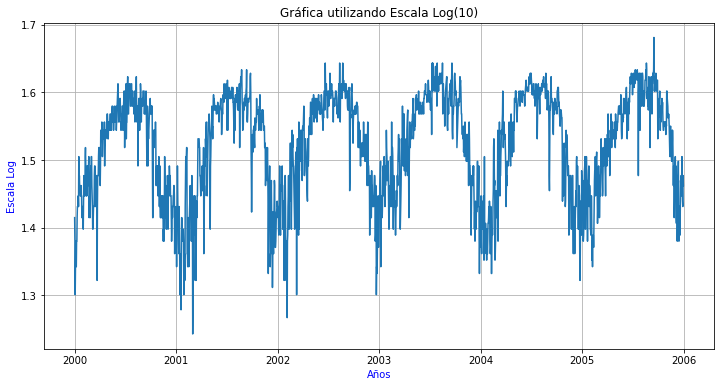

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


Vamos a calcular el Promedio móvil de ts_test_log con ventana de 365 y graficar para ver el contraste con la de arriba

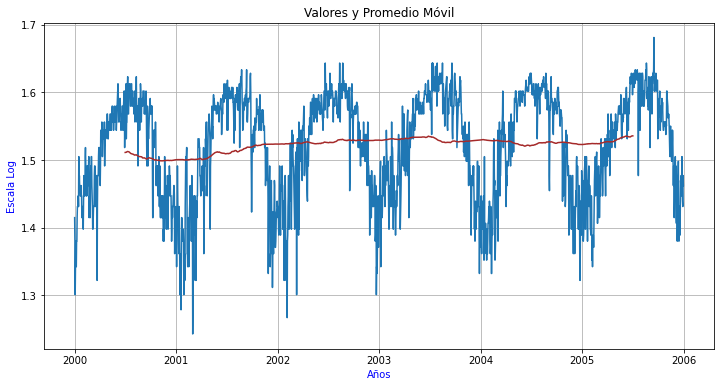

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2000-01-01   NaN
2000-01-02   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
Name: Tmax, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2000-07-01    0.090760
2000-07-02    0.090715
2000-07-03    0.068439
2000-07-04    0.101326
2000-07-05    0.019869
Name: Tmax, dtype: float64

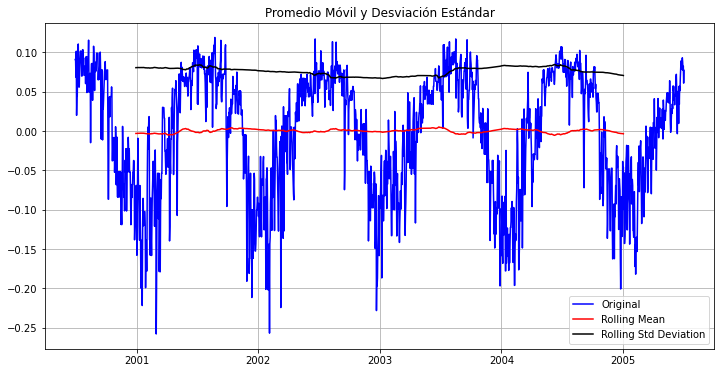

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.839517
p-value                           0.052847
#Lags Used                       20.000000
Number of Observations Used    1807.000000
Critical Value (1%)              -3.433974
Critical Value (5%)              -2.863141
Critical Value (10%)             -2.567622
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial (Exponential Weighted Moving), función de pandas pd.ewm()

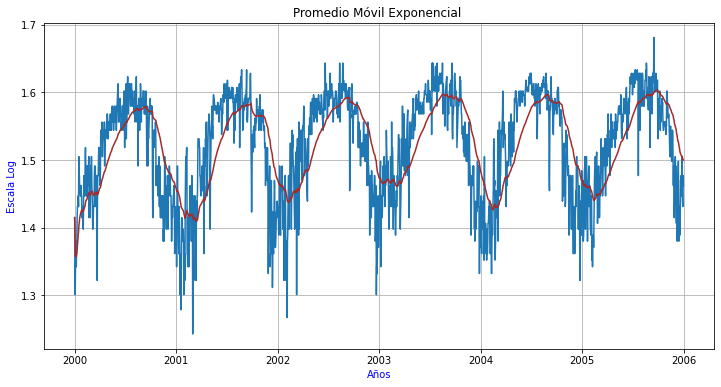

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [ ]:

EWM_avg.head()

Fecha
2000-01-01    1.414973
2000-01-02    1.397392
2000-01-03    1.364526
2000-01-04    1.358807
2000-01-05    1.363288
Name: Tmax, dtype: float64

In [ ]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

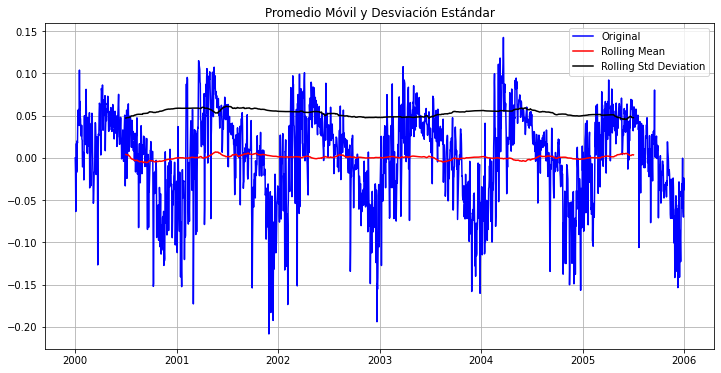

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.966021
p-value                           0.001599
#Lags Used                       20.000000
Number of Observations Used    2171.000000
Critical Value (1%)              -3.433366
Critical Value (5%)              -2.862872
Critical Value (10%)             -2.567479
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

Ahora el valor p < 0.05, es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y **afirmar que la serie de tiempo es estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que **la serie es estacionaria**, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.

Ahora vamos a trabajar con la **estacionalidad** (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estacionalidad:

- Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
- Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada.

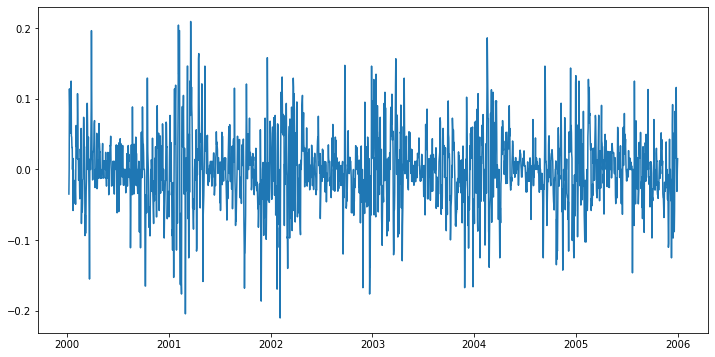

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

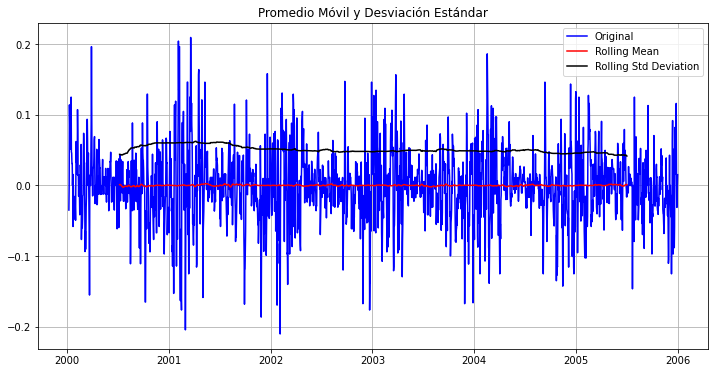

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.960206e+00
p-value                        8.263787e-15
#Lags Used                     2.600000e+01
Number of Observations Used    2.158000e+03
Critical Value (1%)           -3.433384e+00
Critical Value (5%)           -2.862880e+00
Critical Value (10%)          -2.567483e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.

Pero la estacionalidad domina.

Veamos el siguiente **método de descomposición** que utilzamos en la actividad anterior.

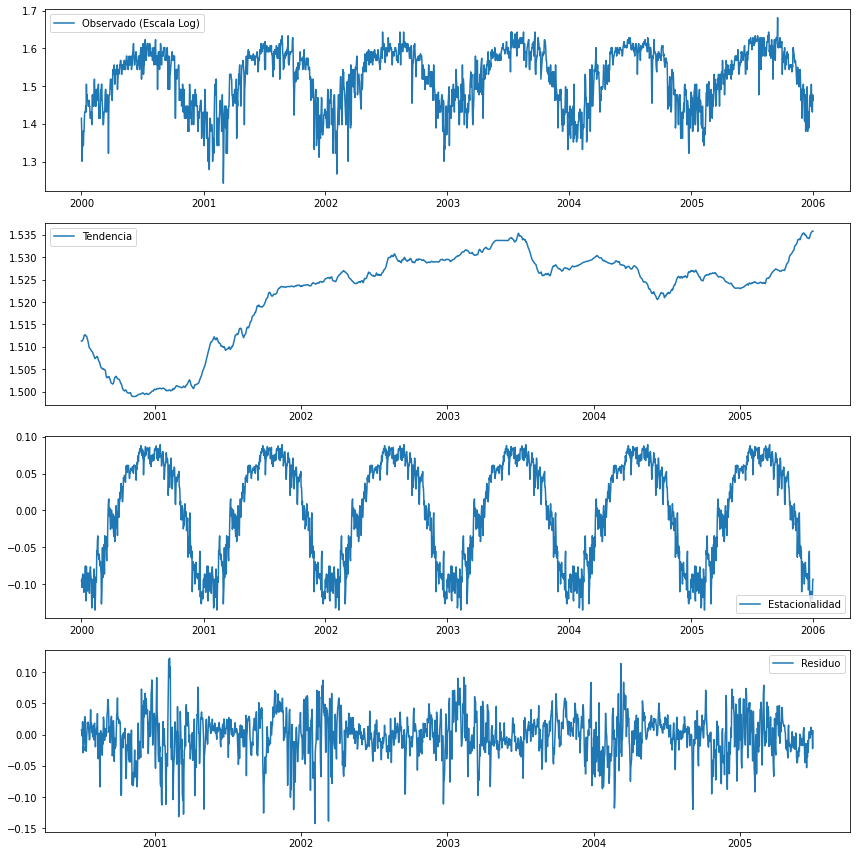

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia(trend), estacionalidad(seasonal) y un residuo(residue)

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

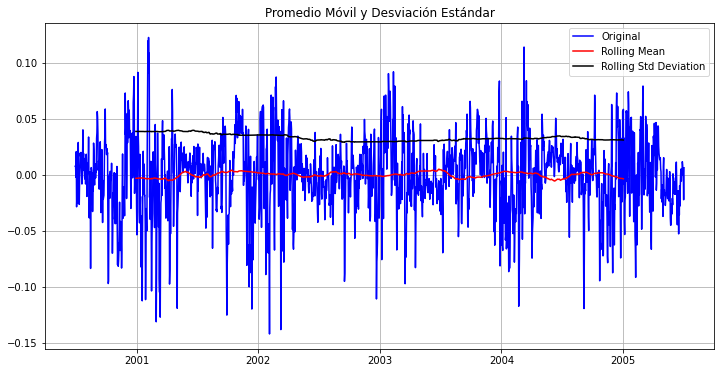

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.589611e+00
p-value                        7.346600e-14
#Lags Used                     2.100000e+01
Number of Observations Used    1.806000e+03
Critical Value (1%)           -3.433976e+00
Critical Value (5%)           -2.863142e+00
Critical Value (10%)          -2.567623e+00
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (4.86 x 10^(-14)). Podemos afirmar que **es una serie de tiempo estacionaria con mas de un 99% de confianza.**

## **Pronóstico de Series de Tiempo**


Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.

Utilizaremos el **método ARIMA**.

Necesitamos agregar las siguientes 2 líneas en la celda 1, donde cargamos las bibliotecas a la memoria de trabajo.

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

Usaremos propiedades de la Distribución Normal centrada en el promedio y std dev=1, donde el 95% de los datos caen entre -1.96 y 1.96.

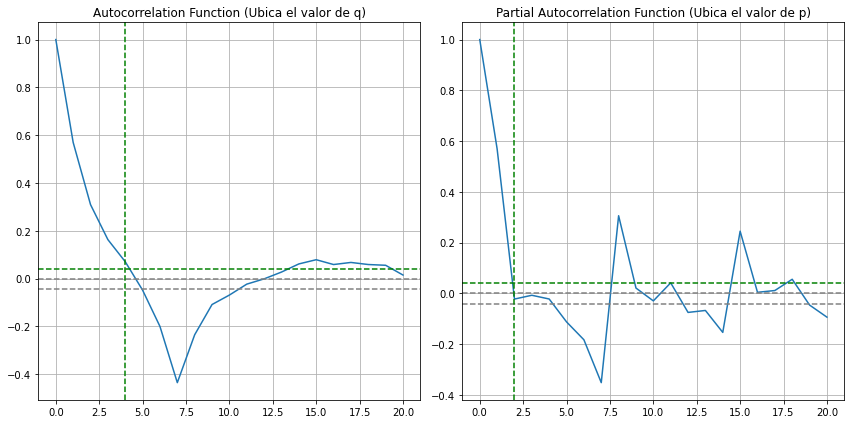

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores **p** y **q** del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.

Con estos dos valores construiremos los modelos ARIMA correspondientes.

# **Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2191
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4491.345
Method:                       css-mle   S.D. of innovations              0.031
Date:                Thu, 18 Feb 2021   AIC                          -8974.690
Time:                        19:31:36   BIC                          -8951.922
Sample:                    01-02-2000   HQIC                         -8966.369
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.029e-05      0.000      0.065      0.948      -0.001       0.001
ar.L1.D.Tmax    -0.2405      0.021    -11.440      0.000      -0.282      -0.199
ar.L2.D.Tmax    -0.1810      0.021     -8.59

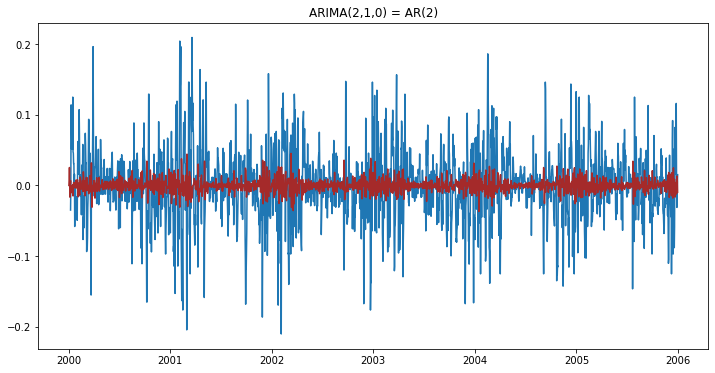

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# **Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2191
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4583.701
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 18 Feb 2021   AIC                          -9155.403
Time:                        19:31:39   BIC                          -9121.250
Sample:                    01-02-2000   HQIC                         -9142.920
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.257e-05      0.000      0.183      0.855      -0.000       0.000
ma.L1.D.Tmax    -0.3396      0.021    -15.951      0.000      -0.381      -0.298
ma.L2.D.Tmax    -0.2112      0.022     -9.51

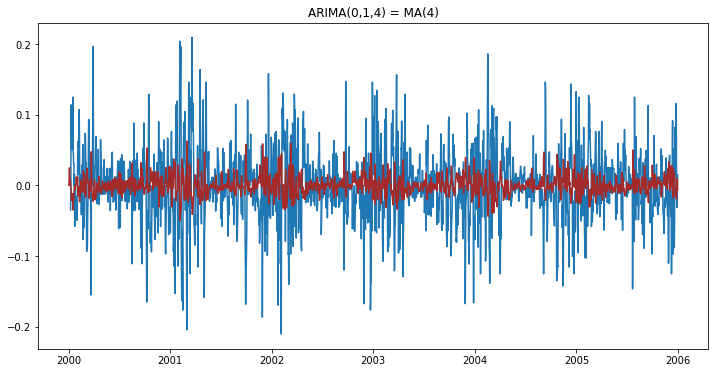

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

#**Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2191
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4585.067
Method:                       css-mle   S.D. of innovations              0.030
Date:                Thu, 18 Feb 2021   AIC                          -9154.134
Time:                        19:31:44   BIC                          -9108.597
Sample:                    01-02-2000   HQIC                         -9137.491
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.115e-05      0.000      0.181      0.857      -0.000       0.000
ar.L1.D.Tmax    -0.0688      0.400     -0.172      0.863      -0.852       0.714
ar.L2.D.Tmax     0.2277      0.140      1.62

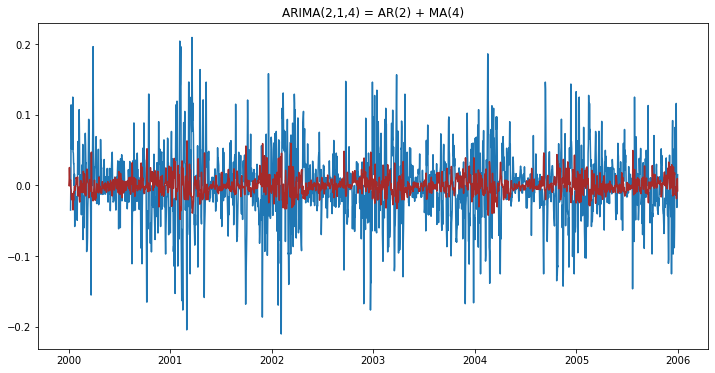

In [ ]:

# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

- Bondad del ajuste
- Simplicidad del modelo o principio de parsimonia.

Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -8974.690

**ARIMA(0,1,4): AIC = -9155.403 <- Es el menor AIC**

ARIMA(2,1,4): AIC = -9154.134 

Podemos afirmar que **ARIMA(0,1,4) es el mejor modelo** de los 3 que exploramos.

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2000-01-02    0.000031
2000-01-03    0.007106
2000-01-04    0.025366
2000-01-05    0.012833
2000-01-06   -0.000760
                ...   
2005-12-27   -0.018640
2005-12-28   -0.004657
2005-12-29    0.005911
2005-12-30    0.009872
2005-12-31   -0.007530
Length: 2191, dtype: float64


In [ ]:

# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2000-01-01         NaN
2000-01-02    1.380242
2000-01-03    1.308136
2000-01-04    1.367788
2000-01-05    1.393044
dtype: float64
Fecha
2005-12-27    1.443758
2005-12-28    1.434676
2005-12-29    1.437275
2005-12-30    1.486993
2005-12-31    1.454868
dtype: float64


El siguiente paso estomar el anti-logaritmo de log(Tmax), i.e. usamos la función 10**log(Tmax).

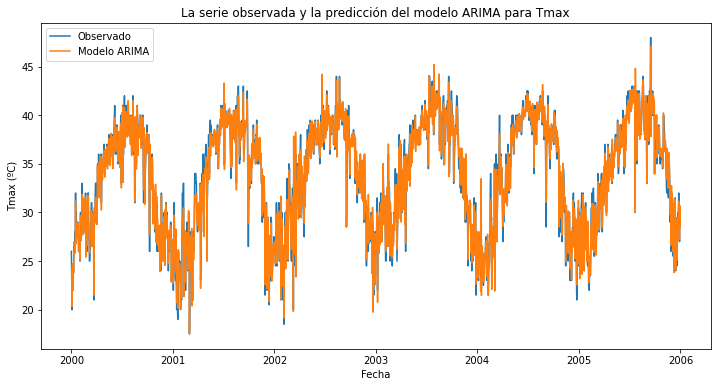

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.8905763209699386


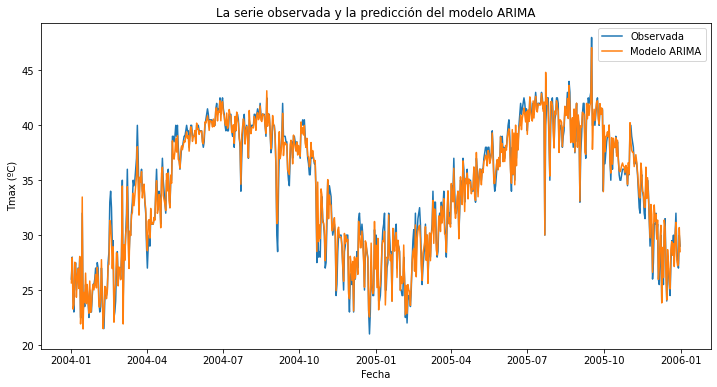

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

# **Para $T_{min}$**.

In [ ]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2000-01', '2005-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2000-01-01,0.0,2.8,26.0,14.0,2000,Jan
2000-01-02,0.0,2.8,24.0,11.0,2000,Jan
2000-01-03,0.0,4.3,20.0,11.0,2000,Jan
2000-01-04,0.0,3.6,22.0,10.0,2000,Jan
2000-01-05,0.0,2.5,24.0,8.0,2000,Jan


In [ ]:
# Vemos su encabezado
ts_90['Tmin'].head()

Fecha
2000-01-01    14.0
2000-01-02    11.0
2000-01-03    11.0
2000-01-04    10.0
2000-01-05     8.0
Name: Tmin, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmin'].copy()

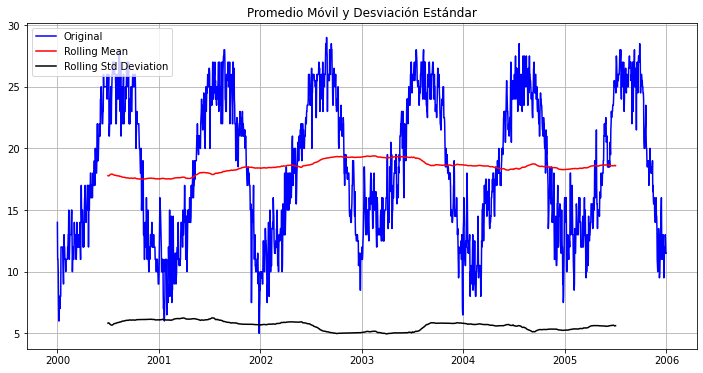

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.704600
p-value                           0.073246
#Lags Used                       11.000000
Number of Observations Used    2180.000000
Critical Value (1%)              -3.433353
Critical Value (5%)              -2.862867
Critical Value (10%)             -2.567476
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test)

Notamos que el promedio móvil no es constante y el valor p de ADF:p>0.05 (0.0732).

La **tendencia** y la **estacionalidad** hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la **Tendencia sea constante**.


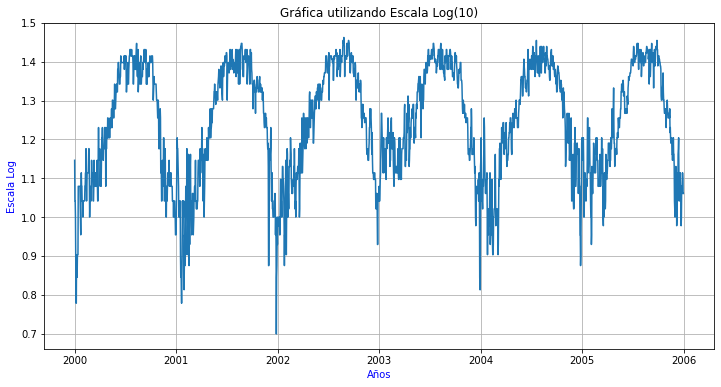

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

Calculamos el Promedio Móvil de st_test_log con ventana de 365 y graficar para ver el contraste con la de arriba.

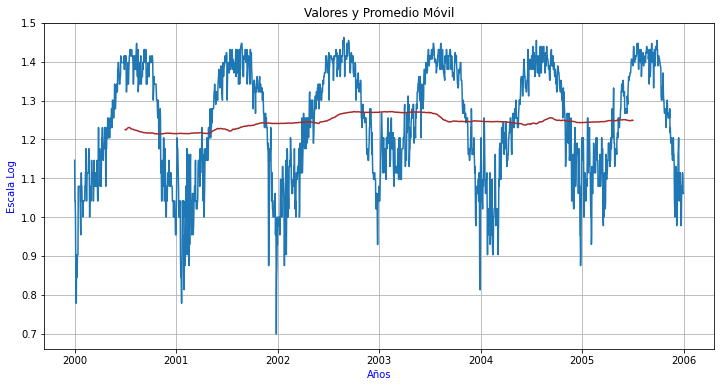

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2000-01-01   NaN
2000-01-02   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
Name: Tmin, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2000-07-01    0.172847
2000-07-02    0.173372
2000-07-03    0.190519
2000-07-04    0.190416
2000-07-05    0.097261
Name: Tmin, dtype: float64

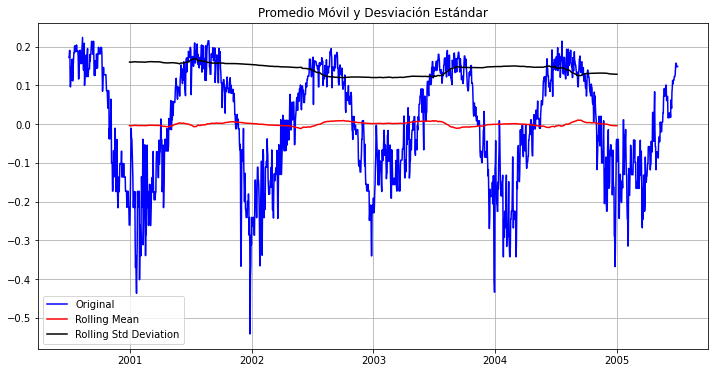

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.569416
p-value                           0.099484
#Lags Used                       11.000000
Number of Observations Used    1816.000000
Critical Value (1%)              -3.433956
Critical Value (5%)              -2.863133
Critical Value (10%)             -2.567618
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

La serie de tiempo aún no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial, función de pandas pd.ewm()

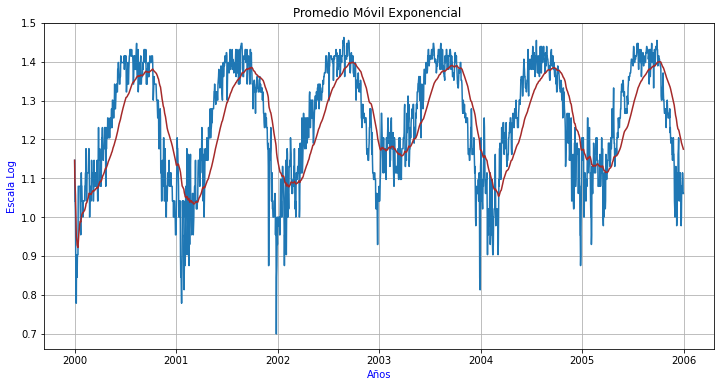

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [ ]:
EWM_avg.head()

Fecha
2000-01-01    1.146128
2000-01-02    1.093155
2000-01-03    1.075501
2000-01-04    1.055967
2000-01-05    1.023962
Name: Tmin, dtype: float64

In [ ]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

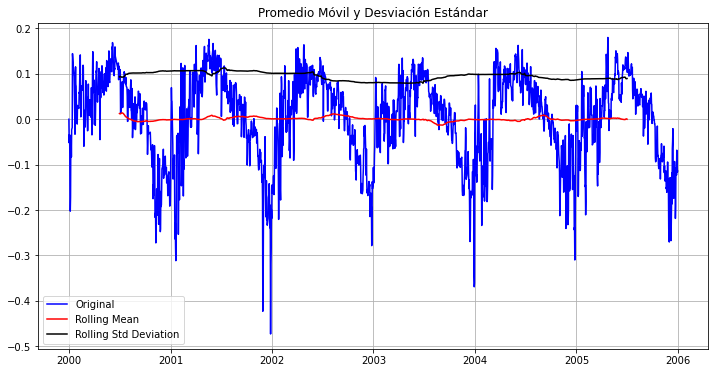

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.780515
p-value                           0.003113
#Lags Used                       12.000000
Number of Observations Used    2179.000000
Critical Value (1%)              -3.433355
Critical Value (5%)              -2.862867
Critical Value (10%)             -2.567477
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)


Ahora el valor p < 0.05, es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y **afirmar que la serie de tiempo es estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que **la serie es estacionaria**, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.

Ahora vamos a trabajar con la **estacionalidad** (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estacionalidad:

- Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
- Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada.

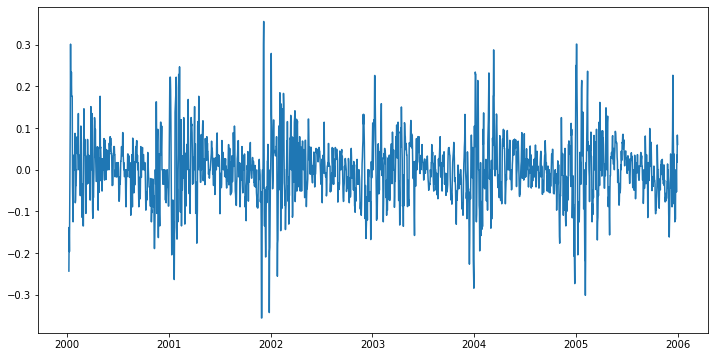

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

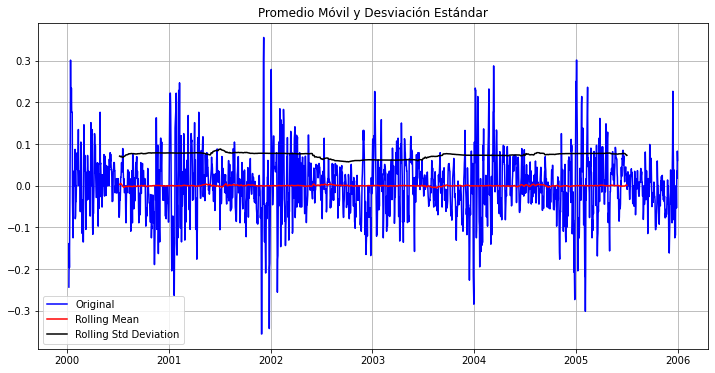

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.094762e+00
p-value                        1.348346e-12
#Lags Used                     2.200000e+01
Number of Observations Used    2.162000e+03
Critical Value (1%)           -3.433378e+00
Critical Value (5%)           -2.862878e+00
Critical Value (10%)          -2.567482e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [ ]:
# Número de datos utilizados
len(ts_test_log_diff)

2185

Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.

Pero la estacionalidad domina.

Veamos el siguiente **método de descomposición** que utilzamos en la actividad anterior.

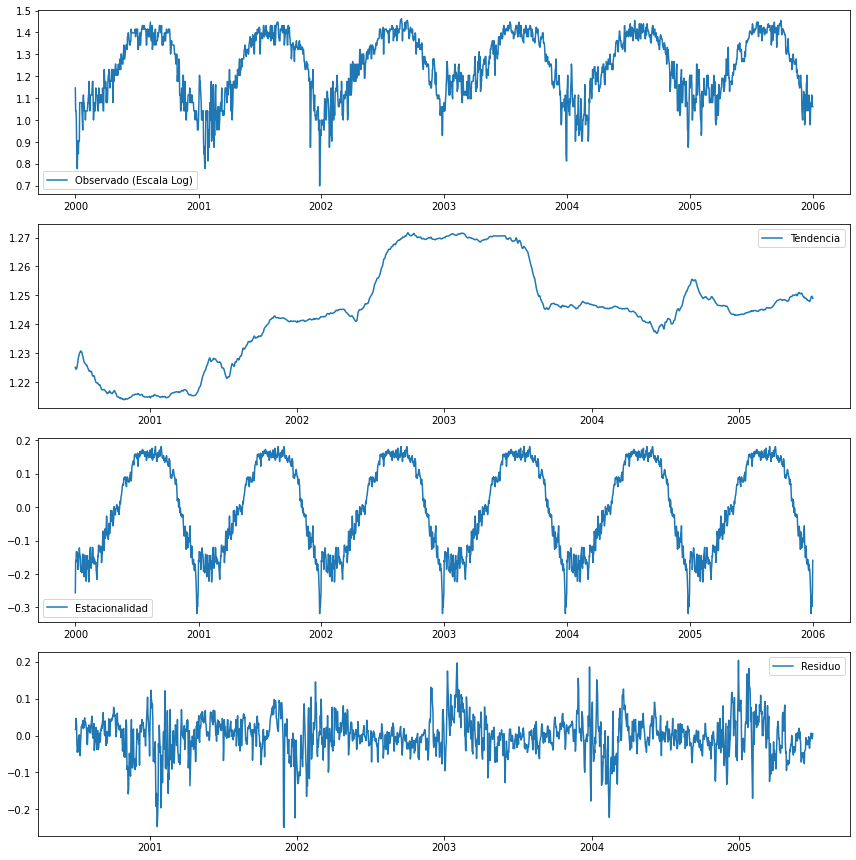

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia(trend), estacionalidad(seasonal) y un residuo(residue)

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

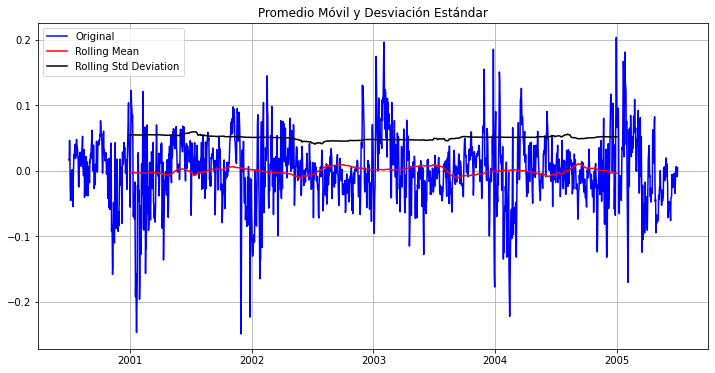

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.783895e+00
p-value                        8.277599e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.816000e+03
Critical Value (1%)           -3.433956e+00
Critical Value (5%)           -2.863133e+00
Critical Value (10%)          -2.567618e+00
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (8.277 x 10^(-12)). Podemos afirmar que **es una serie de tiempo estacionaria con mas de un 99% de confianza**.

# **Pronóstico de Series de Tiempo**

Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.

Utilizaremos el **método ARIMA**.

Necesitamos agregar las siguientes 2 líneas en la celda 1, donde cargamos las bibliotecas a la memoria de trabajo.

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

Usaremos propiedades de la Distribución Normal centrada en el promedio y std dev=1, donde el 95% de los datos caen entre -1.96 y 1.96.

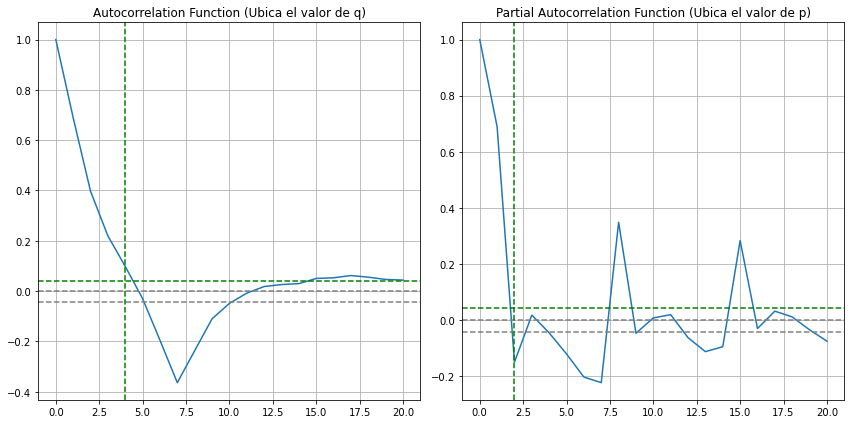

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()


Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores **p** y **q** del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.

Con estos dos valores construiremos los modelos ARIMA correspondientes.

# **Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2191
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3959.526
Method:                       css-mle   S.D. of innovations              0.040
Date:                Thu, 18 Feb 2021   AIC                          -7911.051
Time:                        19:53:23   BIC                          -7888.283
Sample:                    01-02-2000   HQIC                         -7902.730
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -2.7e-05      0.001     -0.040      0.968      -0.001       0.001
ar.L1.D.Tmin    -0.0406      0.021     -1.937      0.053      -0.082       0.000
ar.L2.D.Tmin    -0.2017      0.021     -9.63

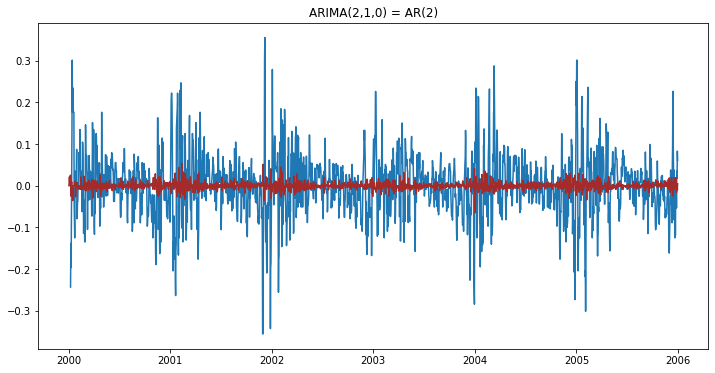

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# **Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2191
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4021.132
Method:                       css-mle   S.D. of innovations              0.039
Date:                Thu, 18 Feb 2021   AIC                          -8030.263
Time:                        19:54:00   BIC                          -7996.111
Sample:                    01-02-2000   HQIC                         -8017.781
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.049e-05      0.000      0.062      0.950      -0.001       0.001
ma.L1.D.Tmin    -0.1187      0.021     -5.568      0.000      -0.160      -0.077
ma.L2.D.Tmin    -0.2667      0.021    -12.61

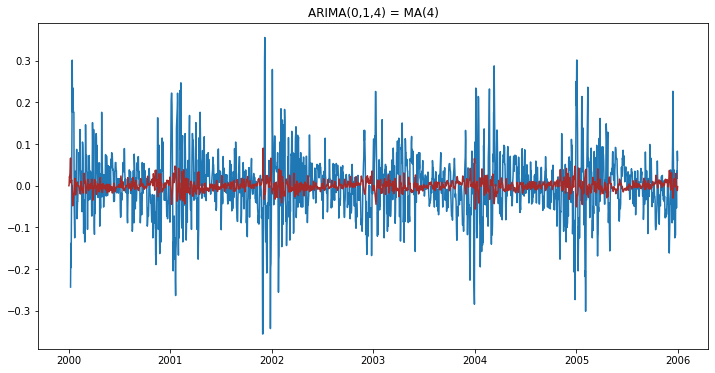

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

# **Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 2191
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4022.392
Method:                       css-mle   S.D. of innovations              0.039
Date:                Thu, 18 Feb 2021   AIC                          -8028.784
Time:                        19:54:59   BIC                          -7983.247
Sample:                    01-02-2000   HQIC                         -8012.141
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          2.15e-05      0.000      0.067      0.946      -0.001       0.001
ar.L1.D.Tmin    -0.0429      0.850     -0.050      0.960      -1.708       1.622
ar.L2.D.Tmin     0.1794      0.322      0.55

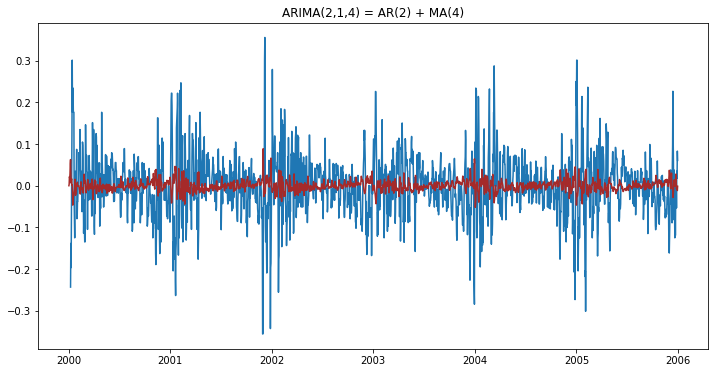

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

Bondad del ajuste
- Simplicidad del modelo o principio de parsimonia.
- Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -7911.051

**ARIMA(0,1,4): AIC = -8030.263 <- Es el menor AIC**

ARIMA(2,1,4): AIC = -8028.784 

Podemos afirmar que **ARIMA(0,1,4) es el mejor modelo** de los 3 que exploramos.

Último paso: Recolectando todo y regresando a la escala original.

Pasos a seguir:

Obtener los valores de la predicción y convertirlos en serie. Observaremos que falta un valor en el inicio (usamos shift=1).
Luego convertir la diferenciación a escala logarímica

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2000-01-02    0.000022
2000-01-03    0.003678
2000-01-04    0.021594
2000-01-05    0.017888
2000-01-06    0.029049
                ...   
2005-12-27   -0.007648
2005-12-28   -0.001633
2005-12-29   -0.004139
2005-12-30   -0.011596
2005-12-31   -0.001352
Length: 2191, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2000-01-01         NaN
2000-01-02    1.041414
2000-01-03    1.045071
2000-01-04    1.021594
2000-01-05    0.920978
dtype: float64
Fecha
2005-12-27    1.053050
2005-12-28    1.112311
2005-12-29    1.092771
2005-12-30    1.049101
2005-12-31    1.059346
dtype: float64


El siguiente paso estomar el anti-logaritmo de log(Tmin), i.e. usamos la función 10**log(Tmin).

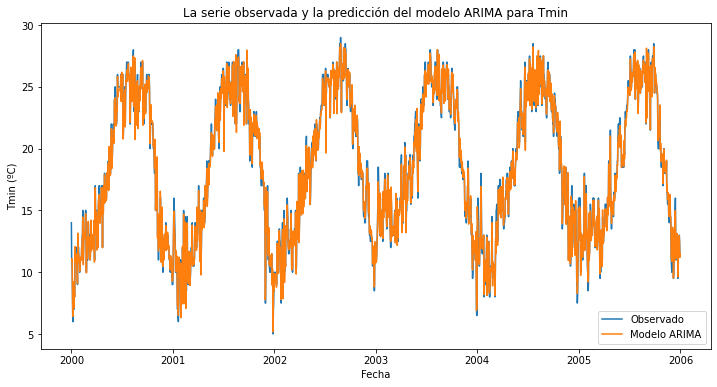

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.4296994331512304


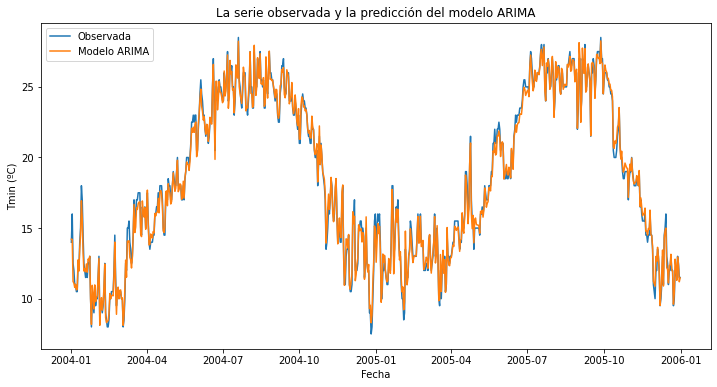

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');